# 1. Camera Calibration

Our initial goal is to obtain a transformation matrix to map a 3D object to a 2D image and a set of coefficients representative of the distortion due to the optics and setting of the image capturing device. Let's import first the main libraries used for this project:


In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
#qt inline
%matplotlib qt

nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

'''
img = mpimg.imread('camera_cal/calibration1.jpg')
plt.imshow(img)
'''

"\nimg = mpimg.imread('camera_cal/calibration1.jpg')\nplt.imshow(img)\n"

The camera calibration function receives a set of images from a source and uses cv2.calibrateCamera to obtain the calibration matrix and distortion coefficients

In [2]:
def camera_calibration(images, nx, ny):
    
    # Prepare object points in the format (0,0,0), (0,1,0),..., (8,8,0)
    objp =  np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x and y coordinates. z value is zero for all points

    # Arrays to store object and image points for all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane
    
    # Step through the list and search for chess corners
    count = 1
    for fname in images:
        img = cv2.imread(fname)
        
        # Convert image to gray scale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        if ret ==  True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            #gray = cv2.drawChessboardCorners(gray, (nx,ny), corners, ret)
            
            # Draw and display corners
            #img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #cv2.imshow('img', img)
            #cv2.waitKey(500)
        
    ret, mtx, dist, rvec, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist
    #cv2.destroyAllWindows()

mtx , dist = camera_calibration(images,nx,ny)

# 2. Distortion correction

The following procedure distort the image and apply color/gradient threshold to clearly identify the lane lines

In [3]:
def undistort_image(img, mtx, dist):
    #1. Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
        
    return undist


## Example of the results so far.

Let's undistort the first chessboard image using the matrix and distortion coefficients obtained after camera calibration.

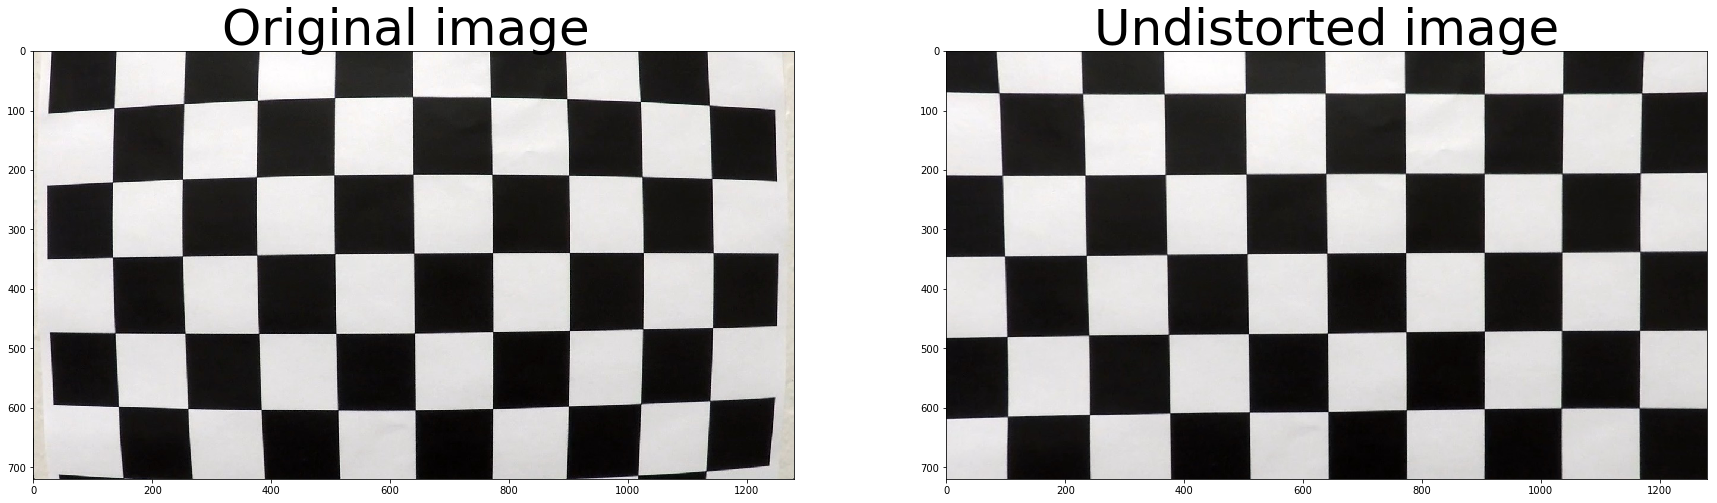

In [4]:
img = mpimg.imread('camera_cal/calibration1.jpg')

undist = undistort_image(img, mtx, dist)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.set_title('Original image ', fontsize=50)
ax1.imshow(img)

ax2.set_title('Undistorted image', fontsize=50)
ax2.imshow(undist)

# 3. Color and gradient thresholds

In [92]:
def threshold_function(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2] # Takes the saturation channel from the image in HLS color space
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Convert rgb image to gray scale
    
    # Threshold over gradient: Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in the x direction
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(sobelx))
    
    #Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= thresh_min) & (scaled_sobelx < thresh_max)] = 1
    
    # Threshold over color: Saturation channel
    s_thresh_min = 150
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min)&( s_channel < s_thresh_max)] = 1
    
    # Stack both channels to see their individual contributions as blue (saturation channel) and green (sobel x)
    color_binary = np.dstack((np.zeros_like(s_channel), sxbinary, s_binary ))*255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(sxbinary==1) | (s_binary==1)] = 1
    
    return combined_binary


## Color and gradient thresholds output

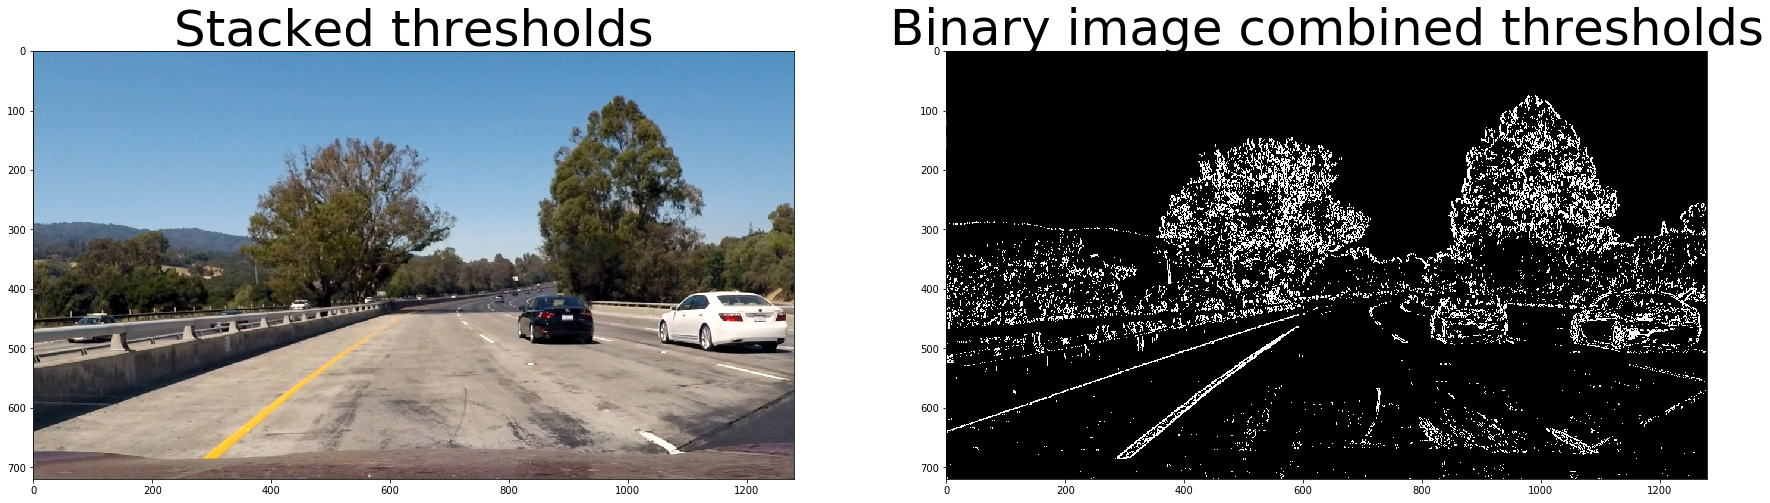

In [93]:
img = mpimg.imread('test_images/test1.jpg')

binary_output=threshold_function(img)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.set_title('Stacked thresholds', fontsize=50)
ax1.imshow(img)

ax2.set_title('Binary image combined thresholds', fontsize=50)
ax2.imshow(binary_output, cmap='gray')
plt.show()

# 4. Perspective transform

Based on previous modifications of the original image now we apply a perspective transform. Our goal is to see the real nature of the lanes as seen from the top down. Lanes should be parallel and clear on the final result

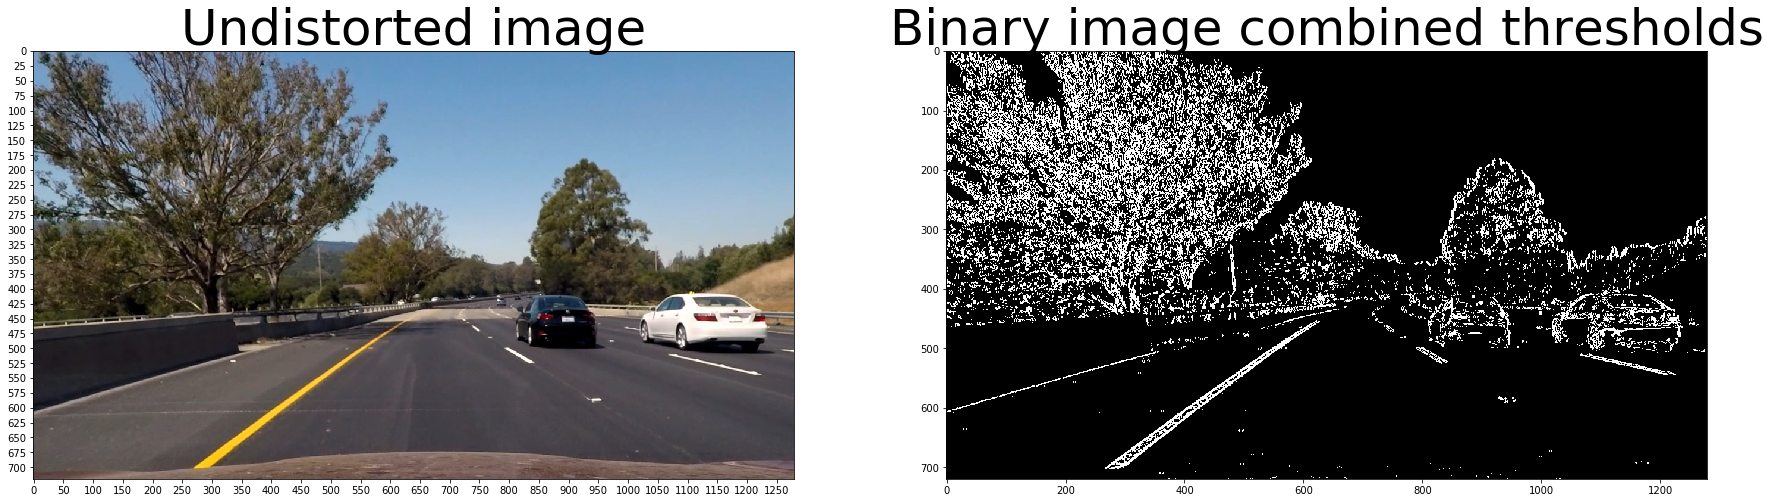

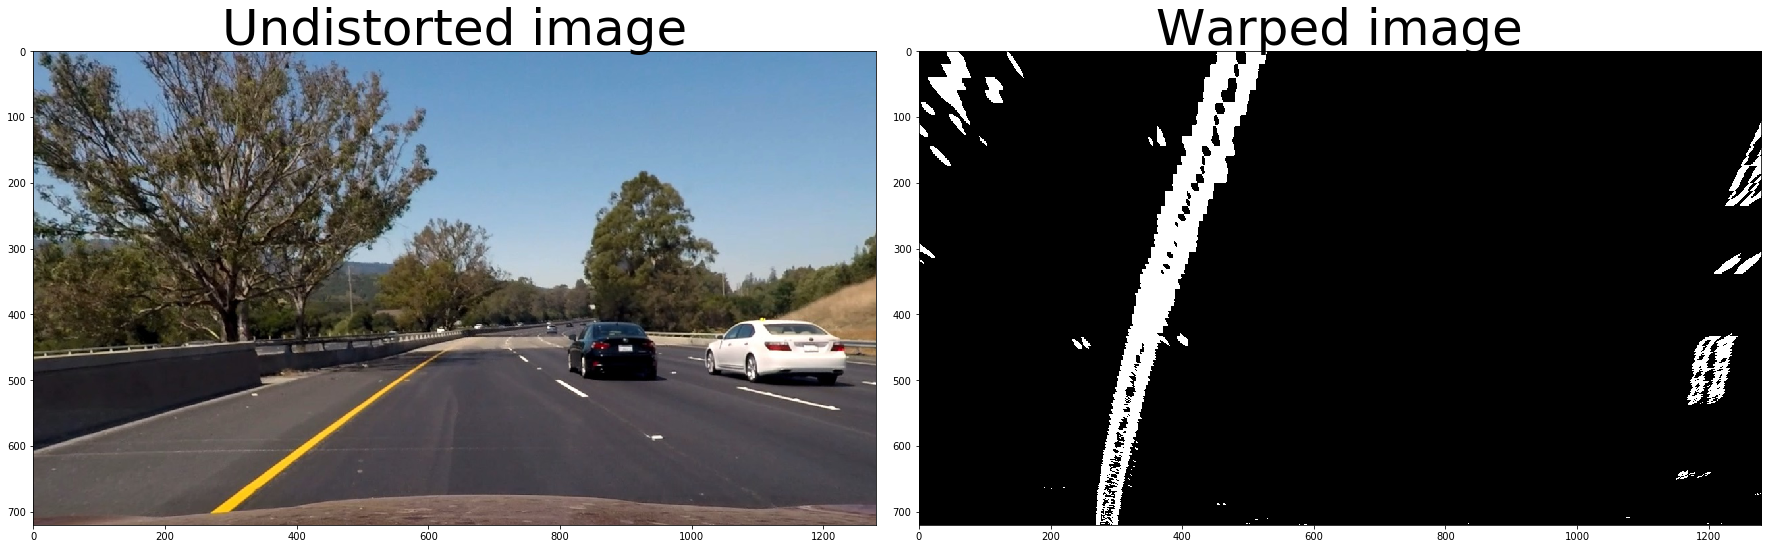

In [99]:
def warped_image(img,mtx,dist):
    
    M = None
    warped = None
    
    offset = 250
    # x and y image sizes
    img_size = (img.shape[1], img.shape[0])

    #b. Define four source points src=np.float32([[,],[,],[,],[,]])
    src = np.float32([[250,img_size[1]-20], [585,460], [701,460], [1060,img_size[1]-20]])

    #c. Define four destination points dst=np.float32([[,],[,],[,],[,]])
    dst = np.float32([[offset,img_size[1]],[offset,50],[img_size[0]-offset+50,50],[img_size[0]-offset+50,img_size[1]]])
    #dst = np.float32([[210,img_size[1]],[210,0],[1130,0],[1130,img_size[1]]])
    #d. Get perspective transform M using the source and destination points
    M = cv2.getPerspectiveTransform(src, dst)

    #e. Warp the image captured by the camera using this transform to get an accurate depiction of the 2D image
    warped = cv2.warpPerspective(img, M,  img_size, flags=cv2.INTER_LINEAR)
    #cv2.INTER_LINEAR    cv2.INTER_NEAREST
    
    return warped, M

#images = glob.glob('test_images/test*.jpg')
images = ['test_images/test6.jpg']
for fname in images:
    img = mpimg.imread(fname)
    undist = undistort_image(img, mtx, dist)
    
    img_thresh = threshold_function(undist)
    
    binary_warped, perspective_M = warped_image(img_thresh, mtx, dist)
    
    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
    ax1.set_title('Undistorted image', fontsize=50)
    ax1.set_xticks(np.arange(0, undist.shape[1], step=50))
    ax1.set_yticks(np.arange(0, undist.shape[0], step=25))
    ax1.imshow(undist)

    ax2.set_title('Binary image combined thresholds', fontsize=50)
    ax2.imshow(img_thresh, cmap='gray')

    f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
    f.tight_layout()
    ax1.imshow(undist)
    ax1.set_title('Undistorted image', fontsize=50)
    ax2.imshow(binary_warped, cmap='gray')
    ax2.set_title('Warped image', fontsize= 50)
    plt.subplots_adjust(left = 0., right = 1, top=0.9, bottom = 0.)
    plt.show()


# 5. Detect lane lines

Here we find the lane lines using histograms and sliding window techniques. We start from the bottom of the image and move upwards trying to map peaks of the histogram to the most populated active pixels in each window. The following segment shows the functions used to detect the lane lines.

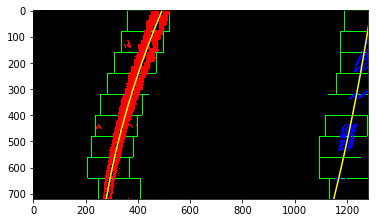

In [105]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### 1.DONE: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin  
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### 2.DONE: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = []
        good_right_inds = []
       
        for i in range(len(nonzerox)):
            
            if nonzerox[i]> binary_warped.shape[1]:
                continue
            # Add nonzero pixels within the windows in left line
            if (nonzerox[i]<win_xleft_high and nonzerox[i]>=win_xleft_low) and \
                (nonzeroy[i]<win_y_high and nonzeroy[i]>=win_y_low):    
                good_left_inds += [i]
            # Add nonzero pixels within the windows in right line    
            if (nonzerox[i]<win_xright_high and nonzerox[i]>=win_xright_low) and \
                (nonzeroy[i]<win_y_high and nonzeroy[i]>=win_y_low):    
                good_right_inds += [i]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        
        ### 3.DONE: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        # If you found > minpix pixels, recenter next window on their mean position
        nleft = 0
        leftx_sum = 0
        for i in good_left_inds:
            nleft +=  1
            leftx_sum += nonzerox[i]
        if nleft > minpix:
            leftx_current =  leftx_sum//nleft

        
        nright = 0
        rightx_sum = 0
        for i in good_right_inds:
            nright +=  1
            rightx_sum += nonzerox[i]
        if nright > minpix:
            rightx_current =  rightx_sum//nright
    

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        print('Something went wrong with the concatenation step!\n')
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[np.uint(left_lane_inds)]
    lefty = nonzeroy[np.uint(left_lane_inds)] 
    rightx = nonzerox[np.uint(right_lane_inds)]
    righty = nonzeroy[np.uint(right_lane_inds)]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ### 4.DONE: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_cr = np.polyfit(ym_per_pix*lefty, xm_per_pix*leftx, 2)
    right_fit_cr = np.polyfit(ym_per_pix*righty, xm_per_pix*rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return left_fit_cr, right_fit_cr, out_img


left_fit_cr, right_fit_cr, out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)

# 6. Determine the lane curvature


In [106]:
def measure_curvature_real(ploty,left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = ym_per_pix*np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**1.5)/np.abs(2*left_fit_cr[0]) 
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**1.5)/np.abs(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

ploty = np.linspace(0,out_img.shape[0]-1, out_img.shape[0])

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr, right_fit_cr)

print('Left lane curvature: '+str(left_curverad)+' m --- '+'Right lane curvature: '+ str(right_curverad)+' m')

Left lane curvature: 959.8022254807709 m --- Right lane curvature: 2489.1791618246607 m
